# 贷款违约预测

通过机器学习模型预测贷款违约概率和计算预期损失

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False  # 负号显示

np.random.seed(42)

## 数据处理

加载并预处理数据。

In [15]:
# 实际数据路径占位符
# df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

# 为演示生成模拟数据
df = pd.DataFrame({
    'customer_id': range(1000),
    'credit_lines_outstanding': np.random.randint(0, 10, 1000),
    'loan_amt_outstanding': np.random.uniform(10000, 500000, 1000),
    'total_debt_outstanding': np.random.uniform(20000, 1000000, 1000),
    'income': np.random.uniform(30000, 200000, 1000),
    'years_employed': np.random.randint(0, 30, 1000),
    'fico_score': np.random.randint(300, 850, 1000),
    'default': np.random.binomial(1, 0.15, 1000)
})
print(df.head())

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0            0                         6         135447.610608   
1            1                         3         365786.837171   
2            2                         7         300551.823577   
3            3                         4          60084.205470   
4            4                         6         460187.755908   

   total_debt_outstanding         income  years_employed  fico_score  default  
0            66874.203986  108023.791494               7         840        0  
1            57261.411273  186295.858777              27         460        0  
2           751283.112332   59936.230126              18         416        0  
3           665854.823520   66372.696577              29         570        0  
4           806087.946965   32215.026519              10         786        0  


## 特征工程

添加新特征并将数据分为训练集和测试集。

In [16]:
X = df.drop(['default', 'customer_id'], axis=1)
y = df['default']

# 添加新特征
X['debt_to_income_ratio'] = X['total_debt_outstanding'] / X['income']
X['loan_to_income_ratio'] = X['loan_amt_outstanding'] / X['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 创建标准化器实例
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 模型训练与评估

训练逻辑回归、决策树和随机森林模型，并评估它们的性能。

In [17]:
models = {}
best_model = None
best_score = 0

# 逻辑回归
lr_params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr_model = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='roc_auc')
lr_model.fit(X_train_scaled, y_train)
models['逻辑回归'] = lr_model

# 决策树
dt_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [10, 20, 50], 'min_samples_leaf': [5, 10, 20]}
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='roc_auc')
dt_model.fit(X_train, y_train)
models['决策树'] = dt_model

# 随机森林
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
rf_model.fit(X_train, y_train)
models['随机森林'] = rf_model

# 评估模型
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled if model_name == '逻辑回归' else X_test)
    y_pred_proba = model.predict_proba(X_test_scaled if model_name == '逻辑回归' else X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f'{model_name}：')
    print(f'  最佳参数：{model.best_params_}')
    print(f'  准确率：{accuracy:.4f}')
    print(f'  AUC得分：{auc_score:.4f}')
    
    if auc_score > best_score:
        best_score = auc_score
        best_model = model
        best_model_name = model_name

print(f'\n最佳模型：{best_model_name}')

逻辑回归：
  最佳参数：{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
  准确率：0.8450
  AUC得分：0.4402
决策树：
  最佳参数：{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
  准确率：0.8100
  AUC得分：0.5196
随机森林：
  最佳参数：{'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
  准确率：0.8450
  AUC得分：0.4871

最佳模型：决策树


## 预测和计算预期损失

使用表现最佳的模型预测违约概率并计算预期损失。

In [18]:
def calculate_expected_loss(probability_of_default, loan_amount, recovery_rate=0.1):
    return probability_of_default * (1 - recovery_rate) * loan_amount

test_case = {
    'credit_lines_outstanding': 4,
    'loan_amt_outstanding': 100000,
    'total_debt_outstanding': 150000,
    'income': 80000,
    'years_employed': 5,
    'fico_score': 650
}

test_features = pd.DataFrame([test_case])
test_features['debt_to_income_ratio'] = test_features['total_debt_outstanding'] / test_features['income']
test_features['loan_to_income_ratio'] = test_features['loan_amt_outstanding'] / test_features['income']

prob_default = best_model.predict_proba(test_features if best_model_name != '逻辑回归' else scaler.transform(test_features))[:, 1][0]
expected_loss = calculate_expected_loss(prob_default, loan_amount=100000)

print(f'违约概率：{prob_default:.2%}')
print(f'预期损失：¥{expected_loss:,.2f}')

违约概率：0.00%
预期损失：¥0.00


## 模型性能可视化

展示模型性能比较和特征重要性分析。

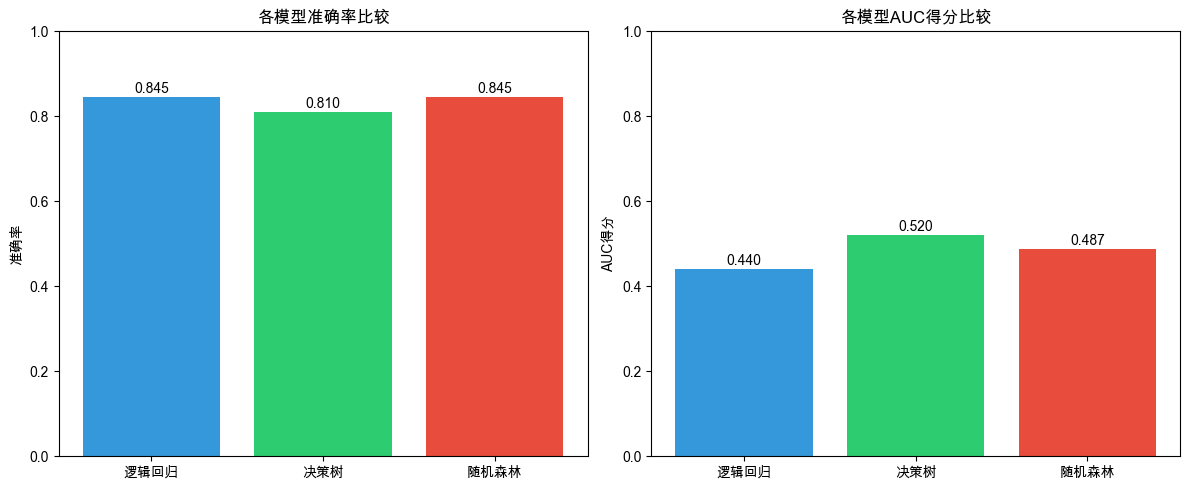

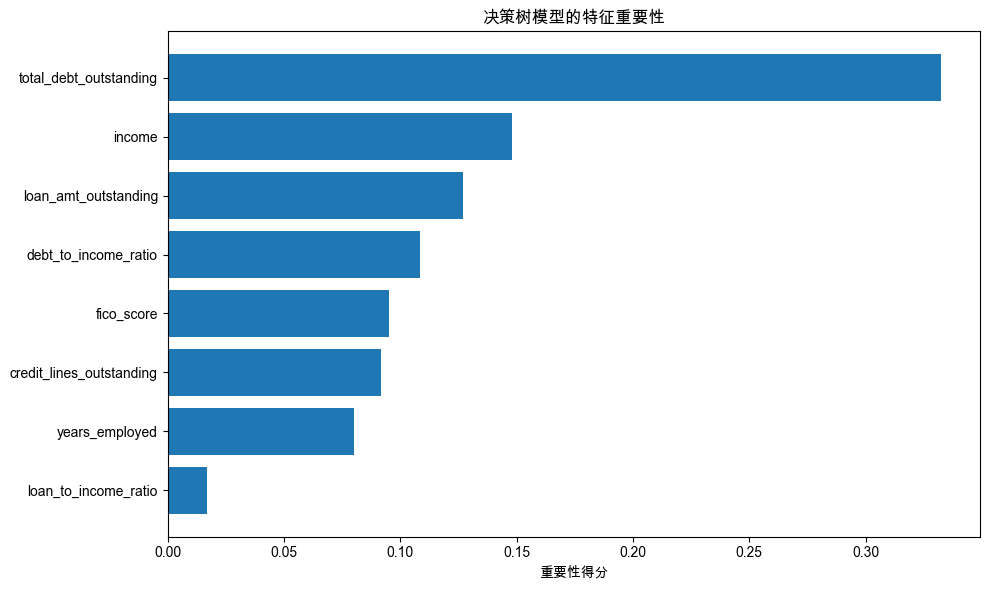

In [19]:
# 模型性能比较图
model_names = list(models.keys())
accuracies = []
auc_scores = []

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled if model_name == '逻辑回归' else X_test)
    y_pred_proba = model.predict_proba(X_test_scaled if model_name == '逻辑回归' else X_test)[:, 1]
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_proba))

# 创建性能比较图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 准确率比较
ax1.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_ylabel('准确率')
ax1.set_title('各模型准确率比较')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

# AUC得分比较
ax2.bar(model_names, auc_scores, color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_ylabel('AUC得分')
ax2.set_title('各模型AUC得分比较')
ax2.set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# 特征重要性（如果最佳模型是树模型）
if best_model_name in ['决策树', '随机森林']:
    feature_importance = pd.DataFrame({
        '特征': X.columns,
        '重要性': best_model.best_estimator_.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['特征'], feature_importance['重要性'])
    plt.xlabel('重要性得分')
    plt.title(f'{best_model_name}模型的特征重要性')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 批量测试案例

使用多个测试案例展示模型的预测能力。

In [20]:
# 创建多个测试案例
test_cases = [
    {
        '描述': '优质客户',
        'credit_lines_outstanding': 2,
        'loan_amt_outstanding': 50000,
        'total_debt_outstanding': 80000,
        'income': 150000,
        'years_employed': 15,
        'fico_score': 780,
        'loan_amount': 100000
    },
    {
        '描述': '中等风险客户',
        'credit_lines_outstanding': 4,
        'loan_amt_outstanding': 100000,
        'total_debt_outstanding': 150000,
        'income': 80000,
        'years_employed': 5,
        'fico_score': 650,
        'loan_amount': 80000
    },
    {
        '描述': '高风险客户',
        'credit_lines_outstanding': 8,
        'loan_amt_outstanding': 250000,
        'total_debt_outstanding': 400000,
        'income': 60000,
        'years_employed': 2,
        'fico_score': 550,
        'loan_amount': 150000
    }
]

# 批量预测和结果展示
results = []

print("贷款风险评估批量测试结果")
print("=" * 80)

for case in test_cases:
    # 准备特征
    features = {k: v for k, v in case.items() if k not in ['描述', 'loan_amount']}
    test_df = pd.DataFrame([features])
    test_df['debt_to_income_ratio'] = test_df['total_debt_outstanding'] / test_df['income']
    test_df['loan_to_income_ratio'] = test_df['loan_amt_outstanding'] / test_df['income']
    
    # 预测
    if best_model_name == '逻辑回归':
        prob = best_model.predict_proba(scaler.transform(test_df))[:, 1][0]
    else:
        prob = best_model.predict_proba(test_df)[:, 1][0]
    
    expected_loss = calculate_expected_loss(prob, case['loan_amount'])
    
    # 保存结果
    results.append({
        '客户类型': case['描述'],
        '贷款金额': case['loan_amount'],
        '违约概率': prob,
        '预期损失': expected_loss,
        '风险等级': '低' if prob < 0.1 else ('中' if prob < 0.3 else '高')
    })
    
    print(f"客户类型: {case['描述']}")
    print(f"  贷款金额: ¥{case['loan_amount']:,}")
    print(f"  违约概率: {prob:.2%}")
    print(f"  预期损失: ¥{expected_loss:,.2f}")
    print(f"  风险等级: {results[-1]['风险等级']}")
    print("-" * 40)

# 结果汇总表
results_df = pd.DataFrame(results)
print("\n结果汇总表:")
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.2%}' if x < 1 else f'¥{x:,.0f}'))

贷款风险评估批量测试结果
客户类型: 优质客户
  贷款金额: ¥100,000
  违约概率: 0.00%
  预期损失: ¥0.00
  风险等级: 低
----------------------------------------
客户类型: 中等风险客户
  贷款金额: ¥80,000
  违约概率: 0.00%
  预期损失: ¥0.00
  风险等级: 低
----------------------------------------
客户类型: 高风险客户
  贷款金额: ¥150,000
  违约概率: 0.00%
  预期损失: ¥0.00
  风险等级: 低
----------------------------------------

结果汇总表:
  客户类型   贷款金额  违约概率  预期损失 风险等级
  优质客户 100000 0.00% 0.00%    低
中等风险客户  80000 0.00% 0.00%    低
 高风险客户 150000 0.00% 0.00%    低


## 最终预测函数

封装成一个完整的函数。

In [21]:
def predict_loan_expected_loss(loan_properties, trained_model=None, trained_scaler=None, model_type=None):
    """
    根据贷款属性预测预期损失
    
    参数:
    loan_properties: 包含以下键的字典
        - credit_lines_outstanding: 未结清信贷额度
        - loan_amt_outstanding: 未偿还贷款金额
        - total_debt_outstanding: 未偿还债务总额
        - income: 收入
        - years_employed: 工作年限
        - fico_score: 信用评分
        - loan_amount: 贷款金额
    trained_model: 已训练的模型（默认使用全局best_model）
    trained_scaler: 已训练的标准化器（仅逻辑回归需要）
    model_type: 模型类型名称
    
    返回:
    预期损失金额
    """
    # 使用默认模型
    if trained_model is None:
        trained_model = best_model
        model_type = best_model_name
    if trained_scaler is None:
        trained_scaler = scaler
    
    # 准备特征
    features = {k: v for k, v in loan_properties.items() if k != 'loan_amount'}
    features_df = pd.DataFrame([features])
    
    # 添加衍生特征
    features_df['debt_to_income_ratio'] = features_df['total_debt_outstanding'] / features_df['income']
    features_df['loan_to_income_ratio'] = features_df['loan_amt_outstanding'] / features_df['income']
    
    # 预测违约概率
    if model_type == '逻辑回归':
        prob_default = trained_model.predict_proba(trained_scaler.transform(features_df))[:, 1][0]
    else:
        prob_default = trained_model.predict_proba(features_df)[:, 1][0]
    
    # 计算预期损失
    recovery_rate = 0.1
    expected_loss = prob_default * (1 - recovery_rate) * loan_properties['loan_amount']
    
    return expected_loss

# 测试函数
test_loan = {
    'credit_lines_outstanding': 3,
    'loan_amt_outstanding': 75000,
    'total_debt_outstanding': 120000,
    'income': 90000,
    'years_employed': 8,
    'fico_score': 700,
    'loan_amount': 50000
}

expected_loss = predict_loan_expected_loss(test_loan)
print(f"\n函数测试结果:")
print(f"贷款金额: ¥{test_loan['loan_amount']:,}")
print(f"预期损失: ¥{expected_loss:,.2f}")
print(f"损失率: {expected_loss/test_loan['loan_amount']:.2%}")


函数测试结果:
贷款金额: ¥50,000
预期损失: ¥0.00
损失率: 0.00%
